In [2]:
import lightning as L
from datasets import Dataset, DatasetDict, load_dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Optional, Tuple
import torch
from torchvision.datasets import MNIST
from PIL import Image
from typing import override
import logging

# CUDA Tensor Core 최적화 설정
torch.set_float32_matmul_precision('medium')  # 'high' for maximum speed, 'medium' for balance

for handler in logging.root.handlers[:]:
    print(handler.name)
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,  
    format="%(asctime)s|%(levelname)s|%(name)s:%(lineno)d| %(message)s"
)
logging.info('============ start ==========')


/Users/cho/workspace/boostcamp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-21 00:59:13,564|INFO|root:23| ============ start ==========


1. 데이타 준비 : LightningDataModule
1. 모델 설계 : LightningModule
1. 학습 설계 : Trainer
1. 학습 수행
1. visualization : latent space 

## 데이타 준비 : LightningDataModule

2025-10-21 01:01:26,405|INFO|root:21| 필터링: [0, 1, 3, 8]
2025-10-21 01:01:27,346|INFO|root:52| X.shape=torch.Size([32, 1, 28, 28]), y.shape=torch.Size([32])


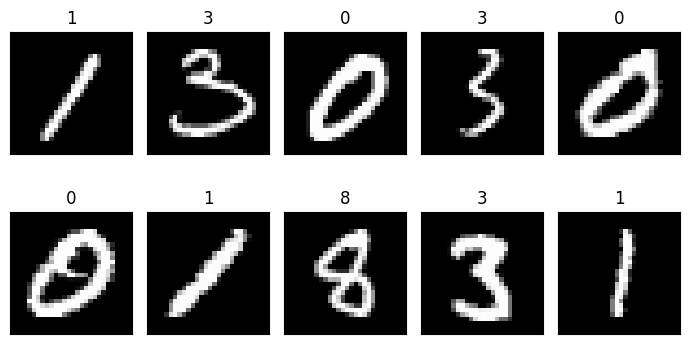

In [3]:
class MNISTDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = '~/workspace/ai/data/', batch_size = 32, target_labels = None):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.target_labels = target_labels
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])

    def _filter_by_labels(self, dataset):
        """특정 레이블만 필터링"""
        indices = [i for i, (_, label) in enumerate(dataset) if label in self.target_labels]
        return torch.utils.data.Subset(dataset, indices)

    def setup(self, stage: str = 'fit'):
        mnist_test_full = MNIST(self.data_dir, train=False, transform=self.transform)
        mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)

        # 특정 레이블만 필터링
        logging.info(f'필터링: {self.target_labels}')
        mnist_test_filtered = self._filter_by_labels(mnist_test_full)
        mnist_train_filtered = self._filter_by_labels(mnist_full)

        # train/val split (약 90/10 비율)
        train_size = int(0.9 * len(mnist_train_filtered))
        val_size = len(mnist_train_filtered) - train_size
        self.mnist_train, self.mnist_val = torch.utils.data.random_split(
            mnist_train_filtered,
            [train_size, val_size]
        )

        self.mnist_test = mnist_test_filtered
        self.mnist_predict = mnist_test_filtered

    def train_dataloader(self):
        return DataLoader(self.mnist_train, shuffle=True, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, shuffle=False, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, shuffle=False, batch_size=self.batch_size)

    def predict_dataloader(self):
        return DataLoader(self.mnist_predict, shuffle=False, batch_size=self.batch_size)

target_labels = [ 0, 1, 3, 8]
mnist = MNISTDataModule(target_labels=target_labels)
mnist.setup('fit')
(X, y) = next(iter(mnist.train_dataloader()))
logging.info(f'X.shape={X.shape}, y.shape={y.shape}')

import matplotlib.pyplot as plt
plt.figure( figsize=(7, 4))
for i in range(10): 
    if i > 10:
        break
    plt.subplot( 2, 5, i+1 )
    plt.title(y[i].item())
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i, 0], cmap='gray', interpolation='none')
plt.tight_layout()


## 모델 설계 : LightningModule

In [4]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(28*28, 256), 
            nn.ReLU(),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        return self.l1(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28)
        )
    
    def forward(self, x):
        return self.l1(x)

In [5]:
import torch.nn.functional as F

class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    @override
    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1) # flatten
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    @override
    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1) # flatten
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = F.mse_loss(x_hat, x)
        self.log("val_loss", val_loss)

    @override
    def test_step(self, batch, batch_idx):
        x, _ = batch
        x = x.view(x.size(0), -1) # flatten
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    @override
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=1e-3,
            weight_decay=0.1
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer=optimizer,
            T_max=100
        )
        return [optimizer], [scheduler]

# Train the model
from torchinfo import summary
encoder = Encoder()
decoder = Decoder()
autoencoder = LitAutoEncoder(encoder, decoder)
summary(autoencoder)

Layer (type:depth-idx)                   Param #
LitAutoEncoder                           --
├─Encoder: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  200,960
│    │    └─ReLU: 3-2                    --
│    │    └─Linear: 3-3                  514
├─Decoder: 1-2                           --
│    └─Sequential: 2-2                   --
│    │    └─Linear: 3-4                  768
│    │    └─ReLU: 3-5                    --
│    │    └─Linear: 3-6                  201,488
Total params: 403,730
Trainable params: 403,730
Non-trainable params: 0

## 학습 설계/수행 : Trainer

In [6]:
from lightning.pytorch.loggers import TensorBoardLogger

# 로거 설정
import datetime
version_name = datetime.datetime.now().strftime("%Y%m%d_%H%M")
logger = TensorBoardLogger(
    save_dir="./logs",
    name="mnist-first",
    version=version_name
    #version=None  # 자동으로 버전 생성
)

# train model
trainer = L.Trainer(
    default_root_dir='./log', 
    max_epochs=20,
    devices="auto",      # 사용 가능한 모든 디바이스 사용
    logger=logger,
    log_every_n_steps=5,
    val_check_interval=1.0,  # 매 epoch마다 validation 수행
    enable_progress_bar=True,
    enable_model_summary=True
)

trainer.fit(autoencoder, mnist)
trainer.test(autoencoder, mnist)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
2025-10-21 01:02:15,004|INFO|root:21| 필터링: [0, 1, 3, 8]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 201 K  | train
1 | decoder | Decoder | 202 K  | train
--------------------------------------------
403 K     Trainable params
0         Non-trainable params
403 K     Total params
1.615     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/cho/workspace/boostcamp/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/cho/workspace/boostcamp/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 694/694 [00:02<00:00, 261.62it/s, v_num=0102]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 694/694 [00:02<00:00, 260.71it/s, v_num=0102]


2025-10-21 01:03:11,875|INFO|root:21| 필터링: [0, 1, 3, 8]
/Users/cho/workspace/boostcamp/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 129/129 [00:00<00:00, 187.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.033797360956668854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.033797360956668854}]

## visualization : latent space 

2025-10-21 01:03:24,652|INFO|root:10| Model is on device: cpu
2025-10-21 01:03:25,024|INFO|root:35| Latent coordinates shape: (22182, 2)
2025-10-21 01:03:25,024|INFO|root:36| Labels shape: (22182,)


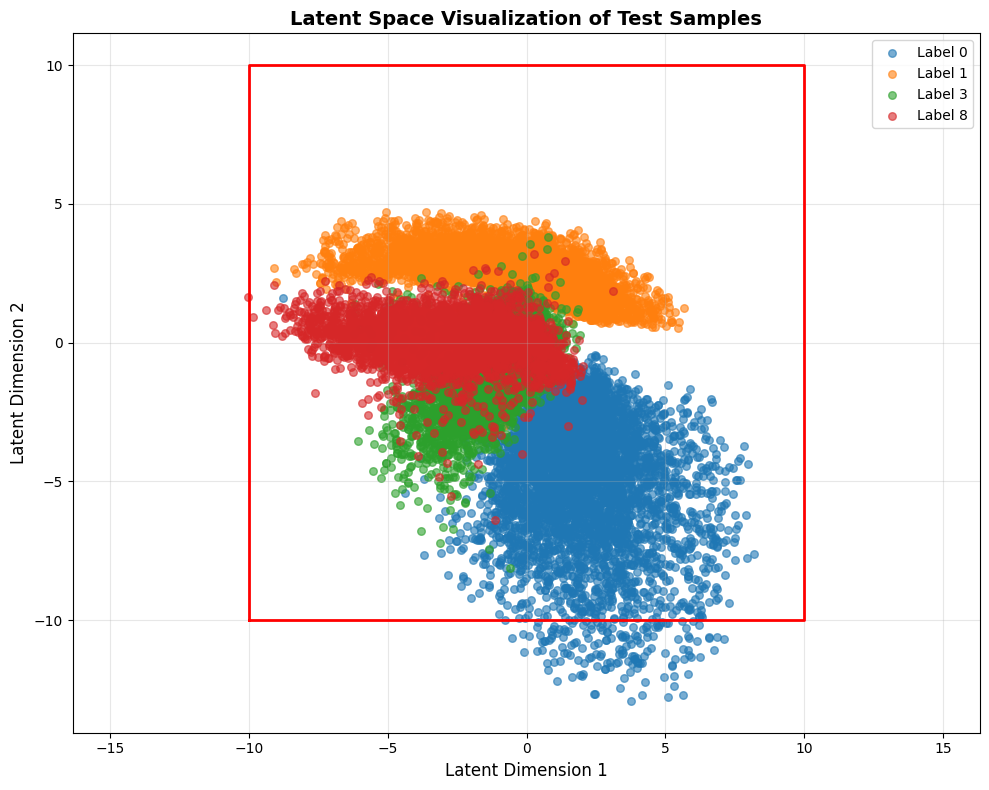


=== Latent Space Statistics ===

Label 0:
  Count: 5310
  Dim 1 - Mean: 1.9603, Std: 1.8004
  Dim 2 - Mean: -4.7482, Std: 2.2974

Label 1:
  Count: 6071
  Dim 1 - Mean: -0.4906, Std: 2.4119
  Dim 2 - Mean: 2.4958, Std: 0.7322

Label 3:
  Count: 5545
  Dim 1 - Mean: -1.1478, Std: 1.1813
  Dim 2 - Mean: -1.0066, Std: 1.2744

Label 8:
  Count: 5256
  Dim 1 - Mean: -2.6520, Std: 1.9689
  Dim 2 - Mean: 0.1249, Std: 0.7482


In [7]:
# Test sample의 latent space 좌표를 추출하고 plot
import matplotlib.pyplot as plt
import numpy as np

# 모델을 evaluation 모드로 설정
autoencoder.eval()

# 모델이 있는 디바이스 확인
device = next(autoencoder.parameters()).device
logging.info(f'Model is on device: {device}')

# test dataloader에서 모든 데이터 가져오기
latent_coords = []
labels = []

with torch.no_grad():
    # for batch in mnist.test_dataloader():
    for batch in mnist.train_dataloader():
        x, y = batch
        x = x.view(x.size(0), -1)  # flatten
        
        # 입력 텐서를 모델과 같은 디바이스로 이동
        x = x.to(device)
        
        # encoder를 통과하여 latent space 좌표 얻기
        z = autoencoder.encoder(x)
        
        latent_coords.append(z.cpu().numpy())
        labels.append(y.cpu().numpy())

# 리스트를 numpy array로 변환
latent_coords = np.concatenate(latent_coords, axis=0)
labels = np.concatenate(labels, axis=0)

logging.info(f'Latent coordinates shape: {latent_coords.shape}')
logging.info(f'Labels shape: {labels.shape}')

# Scatter plot 생성
plt.figure(figsize=(10, 8))

for label in target_labels:
    mask = labels == label
    plt.scatter(
        latent_coords[mask, 0], 
        latent_coords[mask, 1],
        label=f'Label {label}',
        alpha=0.6,
        s=30
    )
    
# 박스 그리기 ([-10, 10] 범위)
box_x = [-10, 10, 10, -10, -10]  # 마지막은 시작점으로 닫기
box_y = [-10, -10, 10, 10, -10]
plt.plot(box_x, box_y, 'r-', linewidth=2)  # 빨간색 실선

plt.xlabel('Latent Dimension 1', fontsize=12)
plt.ylabel('Latent Dimension 2', fontsize=12)
plt.title('Latent Space Visualization of Test Samples', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.axis('equal')
plt.show()

# 통계 정보 출력
print(f"\n=== Latent Space Statistics ===")
for label in target_labels:
    mask = labels == label
    coords = latent_coords[mask]
    print(f"\nLabel {label}:")
    print(f"  Count: {coords.shape[0]}")
    print(f"  Dim 1 - Mean: {coords[:, 0].mean():.4f}, Std: {coords[:, 0].std():.4f}")
    print(f"  Dim 2 - Mean: {coords[:, 1].mean():.4f}, Std: {coords[:, 1].std():.4f}")


### 특정 latent 포인트들로부터 이미지 생성

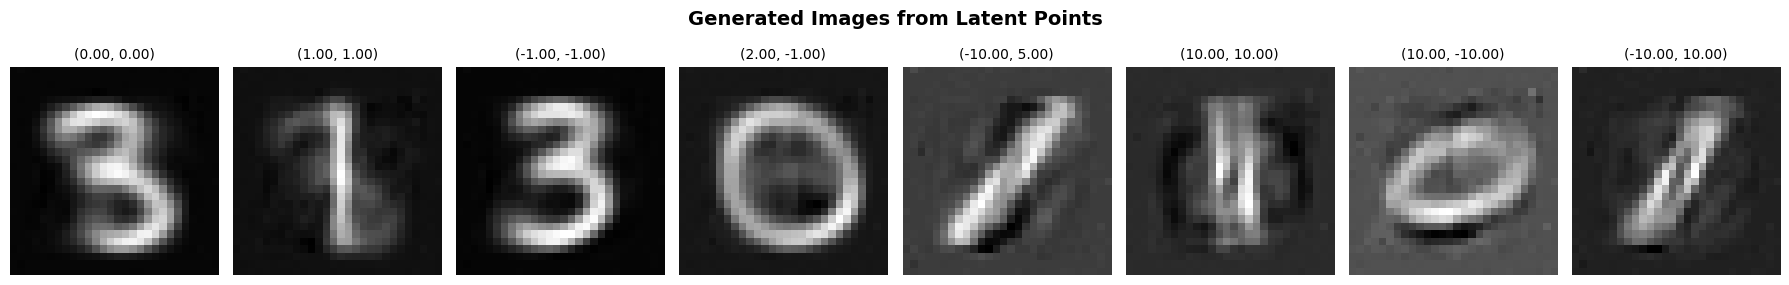

In [8]:
def generate_from_latent(latent_points, model, figsize=(12, 4)):
    """
    latent_points: (n, 2) shape의 numpy array 또는 리스트
    model: LitAutoEncoder 모델
    """
    model.eval()
    
    # 모델이 있는 디바이스 확인
    device = next(model.parameters()).device
    
    # numpy array로 변환
    if isinstance(latent_points, list):
        latent_points = np.array(latent_points)
    
    # tensor로 변환하고 모델과 같은 디바이스로 이동
    latent_tensor = torch.FloatTensor(latent_points).to(device)
    
    # decoder를 통해 이미지 생성
    with torch.no_grad():
        generated_images = model.decoder(latent_tensor)
        generated_images = generated_images.cpu().numpy()
    
    # 이미지를 28x28로 reshape
    generated_images = generated_images.reshape(-1, 28, 28)
    
    # 시각화
    n_images = len(latent_points)
    fig, axes = plt.subplots(1, n_images, figsize=figsize)
    
    if n_images == 1:
        axes = [axes]
    
    for i, (img, point) in enumerate(zip(generated_images, latent_points)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'({point[0]:.2f}, {point[1]:.2f})', fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle('Generated Images from Latent Points', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return generated_images

# 예제: 임의의 latent 포인트에서 이미지 생성
sample_latent_points = [
    [0, 0],      # 원점
    [1, 1],      # 오른쪽 위
    [-1, -1],    # 왼쪽 아래
    [2, -1],     # 오른쪽 아래
    [-10, 5], 
    [10, 10],   
    [10, -10],
    [-10, 10],
]

generated = generate_from_latent(sample_latent_points, autoencoder, figsize=(18, 3))


### 임의의 latent space 포인트로부터 이미지 생성 (Grid 시각화)

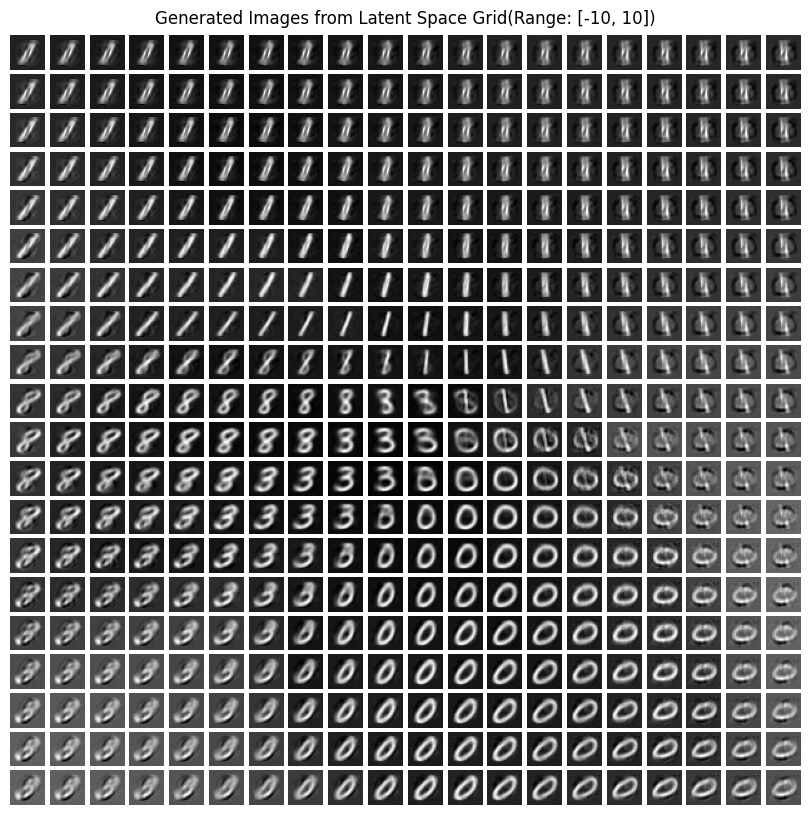

2025-10-21 01:03:35,850|INFO|root:45| Generated 400 images from latent space grid


In [9]:
import matplotlib.pyplot as plt
import torch
import numpy as np

autoencoder.eval()

# 모델이 있는 디바이스 확인
device = next(autoencoder.parameters()).device

# latent space에서 grid 포인트 생성
n_samples = 20  # 한 축당 샘플 개수
latent_range = 10  # latent space 범위 (-latent_range ~ +latent_range)

# latent space의 x, y 좌표 그리드 생성
x = np.linspace(-latent_range, latent_range, n_samples)
y = np.linspace(-latent_range, latent_range, n_samples)
xx, yy = np.meshgrid(x, y)

# 그리드 포인트들을 (n_samples^2, 2) 형태로 변환
latent_points = np.stack([xx.flatten(), np.flip(yy).flatten()], axis=1)

# latent 포인트를 tensor로 변환하고 모델과 같은 디바이스로 이동
latent_tensor = torch.FloatTensor(latent_points).to(device)

# decoder를 통해 이미지 생성
with torch.no_grad():
    generated_images = autoencoder.decoder(latent_tensor)
    generated_images = generated_images.cpu().numpy()

# 이미지를 28x28로 reshape
generated_images = generated_images.reshape(-1, 28, 28)

# 생성된 이미지를 grid로 시각화
fig = plt.figure(figsize=(8, 8))

for i in range(n_samples * n_samples):
    ax = plt.subplot(n_samples, n_samples, i + 1)
    plt.imshow(generated_images[i], cmap='gray')
    plt.axis('off')

plt.suptitle(f'Generated Images from Latent Space Grid(Range: [{-latent_range}, {latent_range}])', y=1)
plt.tight_layout(pad=0.3)
plt.show()

logging.info(f'Generated {n_samples * n_samples} images from latent space grid')
